# Attack dataset
This notebook focuses on the analysis and evaluation of selected models (imported below) for the detection of anomalies. The attack dataset version used here has the following processing steps performed to it

1. Normalization of the columns headers
2. Removal of the following columns since they do not contain additional information compared to the `water_level` columns.
    a. `tank-a_raw_lvl`
    b. `tank-b_raw_lvl`
    c. `tank-a_vol`
    d. `tank-b_vol`
3. Replacing `True` with 1, `False` with 0.  
4. **Note the numerical columns are not scaled!**

In [1]:
# importing necessary analysis libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# import necessary scikit-learn libraries for pipelining
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.base import BaseEstimator, TransformerMixin

## To first test a simple pipeline 
Here, we test constructing a basic pipeline and see if `BaseEstimator` and `TransformerMixin` are required via the following steps:

1. Read the `attackdetected_atk.csv` dataset into `pd.df`
2. Instantialize a `Pipeline` object
3. Change the columns headers to upper case using `df.columns.str.upper()` as part of the pipeline
4. If successful, get `pipeline` to perform the following:
    a. Change all column names to lower case
    b. Drop non-essential columns
    c. Scale columns `tank-a_height`, `tank-b_height` and `total_height`
    d. Cast index with `pd.datetime` method

In [2]:
# read csv into pd.DataFrame
atk_df = pd.read_csv("data/detected_atk.csv", index_col=0, header=0, dayfirst=False, infer_datetime_format=True)
atk_df.head()

,ops_mode_scada_output,pump_start_output,pump_start_scada_input,valve-a_start_scada_input,valve-b_start_scada_input,tank-a_upper_sensor,tank-a_height,tank-a_lower_sensor,tank-b_upper_sensor,tank-b_height,tank-b_lower_sensor,valve-a_hmi_input,valve-a_open,valve-b_hmi_input,valve-b_open,writable_ops_mode_scada_input,total_height,anomalous_seconds,is_anomalous
time,,,,,,,,,,,,,,,,,,,
2022-06-06 14:58:00,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:01,1,1,0,0,0,0,100,1,1,147,1,0,0,0,1,1,247,0.0,0
2022-06-06 14:58:02,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:03,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:04,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0


In [3]:
# write a DataframeFunctionTransformer class to subsequently include in the pipeline
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [4]:
def df_col_to_upper(input_df):
    input_df.columns = input_df.columns.str.strip().str.upper()
    return input_df

def col_to_lower(input_df):
    input_df.columns = input_df.columns.str.strip().str.lower()
    return input_df

def idx_to_datetime(input_df):
    tfm_df = input_df.copy()
    tfm_df.index = pd.to_datetime(input_df.index,
                                            errors='raise', 
                                            yearfirst=True,
                                            format='%Y-%m-%d %H:%M:%S')
    return tfm_df

def drop_col(input_df, col_to_drop, axis=1):
    output_df = input_df.drop(col_to_drop, axis=1)
    return output_df

In [5]:
scale_cols = ColumnTransformer([("col_scalar", StandardScaler(), ['tank-a_height', 'tank-b_height', 'total_height'])], remainder="passthrough")

pipeline = Pipeline([("col_to_lower", DataframeFunctionTransformer(col_to_lower)),
                    ("datetime_idx", DataframeFunctionTransformer(idx_to_datetime)),
                    ("drop_col", FunctionTransformer(func=drop_col, kw_args={"col_to_drop": ['is_anomalous', 'anomalous_seconds']})),
                    ("scalar", scale_cols)])

In [6]:
atk_df = pd.read_csv("data/detected_atk.csv", header=0, index_col=0, parse_dates=True)
atk_df.columns = atk_df.columns.str.strip().str.upper()
atk_df.head()

,OPS_MODE_SCADA_OUTPUT,PUMP_START_OUTPUT,PUMP_START_SCADA_INPUT,VALVE-A_START_SCADA_INPUT,VALVE-B_START_SCADA_INPUT,TANK-A_UPPER_SENSOR,TANK-A_HEIGHT,TANK-A_LOWER_SENSOR,TANK-B_UPPER_SENSOR,TANK-B_HEIGHT,TANK-B_LOWER_SENSOR,VALVE-A_HMI_INPUT,VALVE-A_OPEN,VALVE-B_HMI_INPUT,VALVE-B_OPEN,WRITABLE_OPS_MODE_SCADA_INPUT,TOTAL_HEIGHT,ANOMALOUS_SECONDS,IS_ANOMALOUS
time,,,,,,,,,,,,,,,,,,,
2022-06-06 14:58:00,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:01,1,1,0,0,0,0,100,1,1,147,1,0,0,0,1,1,247,0.0,0
2022-06-06 14:58:02,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:03,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0
2022-06-06 14:58:04,1,1,0,0,0,0,100,1,1,148,1,0,0,0,1,1,248,0.0,0


In [7]:
atk_arr = pipeline.fit_transform(atk_df)
col = ['tank-a_height', 'tank-b_height', 'total_height'] + [col for col in atk_df.columns if col not in ['tank-a_height', 'tank-b_height', 'total_height']]
atk_scaled_df = pd.DataFrame(atk_arr, columns=col[:-2], index=atk_df.index)
atk_scaled_df.head()

,tank-a_height,tank-b_height,total_height,ops_mode_scada_output,pump_start_output,pump_start_scada_input,valve-a_start_scada_input,valve-b_start_scada_input,tank-a_upper_sensor,tank-a_lower_sensor,tank-b_upper_sensor,tank-b_lower_sensor,valve-a_hmi_input,valve-a_open,valve-b_hmi_input,valve-b_open,writable_ops_mode_scada_input
time,,,,,,,,,,,,,,,,,
2022-06-06 14:58:00,-1.154762,1.290213,0.663787,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2022-06-06 14:58:01,-1.154762,1.258715,0.559840,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2022-06-06 14:58:02,-1.154762,1.290213,0.663787,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2022-06-06 14:58:03,-1.154762,1.290213,0.663787,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2022-06-06 14:58:04,-1.154762,1.290213,0.663787,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


## Fit AD models to Attack dataset
Now that the data has been prepared, fit the identified AD models to the dataset and check their performance.

In [8]:
# importing required AD models
# from pyod.models.iforest import IForest
# from pyod.models.ocsvm import OCSVM
# from pyod.models.lof import LOF
# from pyod.models.hbos import HBOS   # assumes feature-independence
# from pyod.models.ecod import ECOD   # based on empirical CDF distributionsrom
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, roc_auc_score, recall_score, f1_score

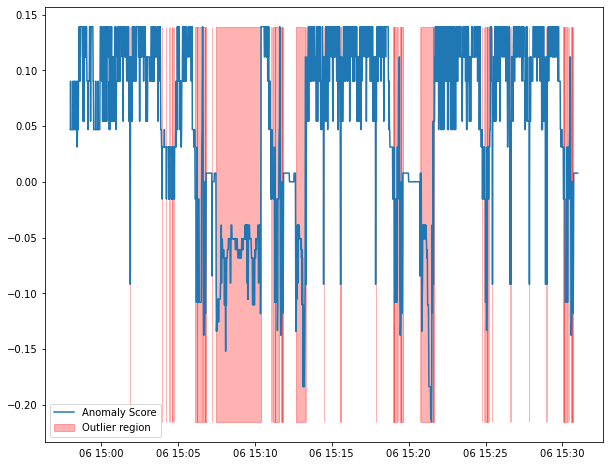

In [35]:
iso = IsolationForest(contamination=0.25, max_features=0.2)
outlier = iso.fit_predict(atk_scaled_df['total_height'].to_numpy().reshape(-1, 1))
anomaly_score = iso.decision_function(atk_scaled_df['total_height'].to_numpy().reshape(-1,1))
plt.figure(figsize=(10,8))
xx = np.arange(len(atk_scaled_df))
# plt.plot(np.arange(len(atk_scaled_df)), anomaly_score, label='Anomaly Score')
plt.plot(atk_scaled_df.index, anomaly_score, label='Anomaly Score')
plt.fill_between(atk_scaled_df.index, np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=0.3, label='Outlier region')
plt.legend()
plt.show()

array([-1,  1])

In [ ]:
contam = np.arange(0.1, 0.40, 0.05)
num_feature = np.arange(3, 17, 1)

In [ ]:
# accuracy = []
# f1 = []
# precision = []
# recall = []
# roc = []
# for cont in contam:
#     for feat in num_feature:
#         iso = IsolationForest(contamination=cont, max_features=feat, random_state=42, warm_start=False)
#         iso.fit(atk_scaled_df)
#         valid_df = atk_df[['is_anomalous']]
#         valid_df.index = atk_df.index
#         valid_df['prediction'] = iso.predict(atk_scaled_df)
#         valid_df['prediction'].replace({1: 0, -1: 1}, inplace=True)
#         valid_df['scores'] = iso.decision_function(atk_scaled_df)
#         print(80 * '=')
#         print(f"Contamination levels: {cont}\t\tNumber of features: {feat}\n")
#         # print(f"model accuracy: {accuracy_score(valid_df['is_anomalous'], valid_df['prediction'], normalize=True):.3f}")
#         accuracy.append(accuracy_score(valid_df['is_anomalous'], valid_df['prediction'], normalize=True))
#         # print(f"model f1-score: {f1_score(valid_df['is_anomalous'], valid_df['prediction']):.3f}")
#         f1.append(f1_score(valid_df['is_anomalous'], valid_df['prediction']))
#         # print(f"model precision: {precision_score(valid_df['is_anomalous'], valid_df['prediction']):.3f}")
#         precision.append(precision_score(valid_df['is_anomalous'], valid_df['prediction']))
#         # print(f"recall score: {recall_score(valid_df['is_anomalous'], valid_df['prediction']):.3f}") 
#         recall.append(recall_score(valid_df['is_anomalous'], valid_df['prediction']))
#         # print(f"roc_auc score: {roc_auc_score(valid_df['is_anomalous'], valid_df['scores']):.3f}")
#         roc.append(roc_auc_score(valid_df['is_anomalous'], valid_df['scores']))

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# precision = np.array(precision)
# precision[np.argmax(precision)] # max precision correspond to cont=0.2, num_features = 9

In [ ]:
iso = IsolationForest(contamination=0.2, max_features=0.6, random_state=42, warm_start=False)
iso.fit(atk_scaled_df)

In [ ]:
atk_df['prediction'] = iso.predict(atk_scaled_df)
atk_df['prediction'].replace({1: 0, -1: 1}, inplace=True)
atk_df['scores'] = iso.decision_function(atk_scaled_df)
# atk_df.head()

In [ ]:
pred_anomaly = atk_df.loc[atk_df['prediction'] == 1]
pred_anomaly_index = list(pred_anomaly.index)
# pred_anomaly_index

In [ ]:
print(f"model accuracy: {accuracy_score(atk_df['is_anomalous'], atk_df['prediction'], normalize=True):.3f}")
print(f"model precision: {precision_score(atk_df['is_anomalous'], atk_df['prediction']):.3f}")
print(f"model average precision: {average_precision_score(atk_df['is_anomalous'], atk_df['scores']):.3f}")  
print(f"roc_auc score: {roc_auc_score(atk_df['is_anomalous'], atk_df['scores']):.3f}")
print(f"recall score: {recall_score(atk_df['is_anomalous'], atk_df['prediction']):.3f}")  
print(f"f1 score: {f1_score(atk_df['is_anomalous'], atk_df['prediction']):.3f}")  